# Imports

In [2]:
import numpy as np
import ot
from SVM_Experiments import SVMExperiment
from Data.LatentDataset import LatentFMRIDataset
import matplotlib.pylab as pl
import ot.plot
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Dataset preparations

In [3]:
nyu_dataset_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/NYU_all'
um1_dataset_directory = '/Users/balazsmorvay/PycharmProjects/VAE/Assets/UM_1_all'

In [4]:
nyu_data = LatentFMRIDataset(data_dir=nyu_dataset_directory).get_all_items()
um1_data = LatentFMRIDataset(data_dir=um1_dataset_directory).get_all_items()

In [5]:
n_data = -1
train_test_split = 0.9

In [6]:
X_nyu = nyu_data['X']
y_nyu = nyu_data['y']
X_um1 = um1_data['X']
y_um1 = um1_data['y']

X_um1, y_um1 = shuffle(X_um1, y_um1, random_state=41) # Shuffle to mix the labels

X_nyu = X_nyu.reshape((X_nyu.shape[0], -1))[0:n_data]
X_um1 = X_um1.reshape((X_um1.shape[0], -1))[0:n_data]
y_nyu = y_nyu[0:n_data]
y_um1 = y_um1[0:n_data]

# Train test split of UM1
X_um1_train = X_um1[:int(train_test_split*X_um1.shape[0])]
X_um1_test = X_um1[int(train_test_split*X_um1.shape[0]):]
y_um1_train = y_um1[:int(train_test_split*y_um1.shape[0])]
y_um1_test = y_um1[int(train_test_split*y_um1.shape[0]):]

In [7]:
X_nyu.shape, y_nyu.shape, X_um1_train.shape, y_um1_train.shape, X_um1_test.shape, y_um1_test.shape

((29574, 1152), (29574,), (21239, 1152), (21239,), (2360, 1152), (2360,))

In [8]:
# Source: UM1 train, Target: NYU
Xs = X_um1_train
ys = y_um1_train

Xt = X_nyu
yt = y_nyu

In [9]:
ys_1, ys_2 = 0, 0
for i in range(len(ys)):
    if ys[i] == 1: ys_1 += 1
    if ys[i] == 2: ys_2 += 1
ys_1, ys_2

(9015, 12224)

In [10]:
yt_1, yt_2 = 0, 0
for i in range(len(yt)):
    if yt[i] == 1: yt_1 += 1
    if yt[i] == 2: yt_2 += 1
yt_1, yt_2

(12600, 16974)

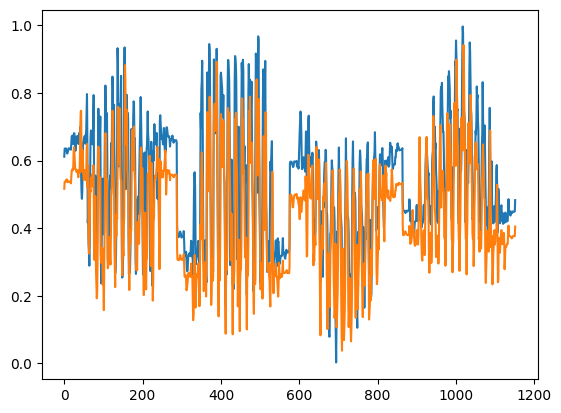

In [11]:
plt.plot(Xs[1000])
plt.plot(Xt[1000])
plt.show()

# Computing the optimal transport plan

In [12]:
ot_sinkhorn = ot.da.UnbalancedSinkhornTransport(reg_e=1.0, reg_m=0.1, max_iter=10000, method='sinkhorn_stabilized', verbose=True, log=True)

ot_sinkhorn.fit(Xs, ys, Xt, yt)
Xst = ot_sinkhorn.transform(Xs=Xs)

It.  |Err         
-------------------
    0|9.131322e-01|
   10|9.643984e-18|


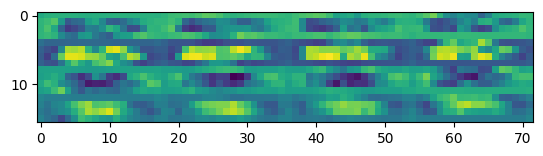

In [28]:
pl.imshow(f4.reshape(16, 72))

Conv barycenter az eredeti fmri képekre és a látensekre is, a látens baricentereket visszaalakítani fmri-vé a dekóderrel, megnézni mennyire hasonlítanak

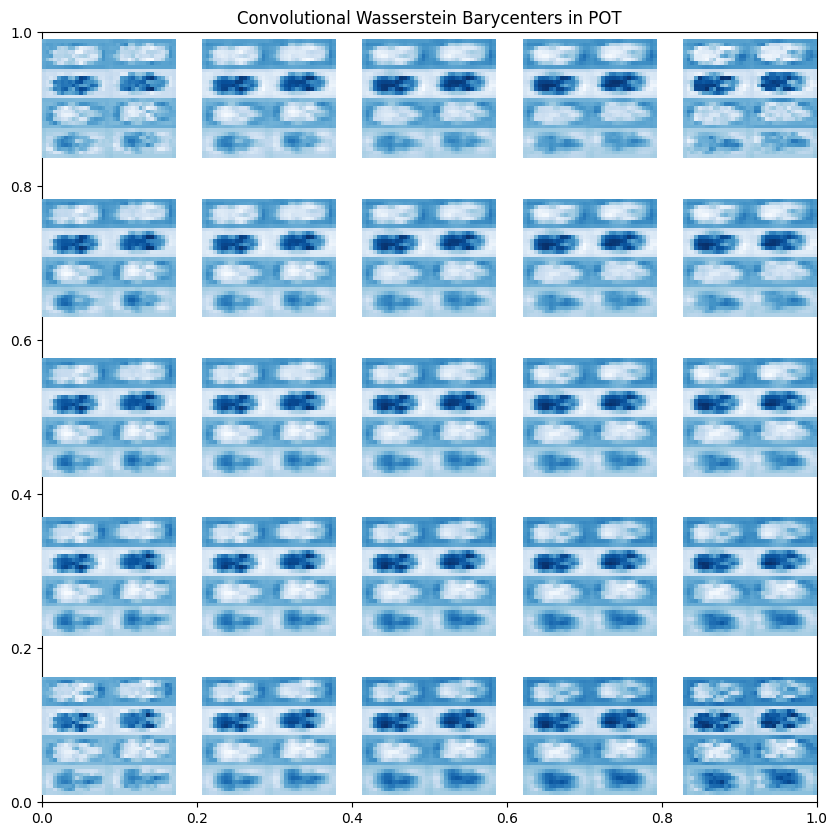

In [32]:
import matplotlib.pylab as pl
import torch

f1 = X_nyu[0].reshape((32, 36))
f2 = X_nyu[1].reshape((32, 36))
f3 = X_um1[0].reshape((32, 36))
f4 = X_um1[1].reshape((32, 36))

f1 = f1 / np.sum(f1)
f2 = f2 / np.sum(f2)
f3 = f3 / np.sum(f3)
f4 = f4 / np.sum(f4)

A = [f1, f2, f3, f4]

v1 = np.array((1, 0, 0, 0))
v2 = np.array((0, 1, 0, 0))
v3 = np.array((0, 0, 1, 0))
v4 = np.array((0, 0, 0, 1))

nb_images = 5

pl.figure(figsize=(10, 10))
pl.title('Convolutional Wasserstein Barycenters in POT')
cm = 'Blues'
# regularization parameter
reg = 0.0005
for i in range(nb_images):
    for j in range(nb_images):
        pl.subplot(nb_images, nb_images, i * nb_images + j + 1)
        tx = float(i) / (nb_images - 1)
        ty = float(j) / (nb_images - 1)

        # weights are constructed by bilinear interpolation
        tmp1 = (1 - tx) * v1 + tx * v2
        tmp2 = (1 - tx) * v3 + tx * v4
        weights = (1 - ty) * tmp1 + ty * tmp2

        if i == 0 and j == 0:
            pl.imshow(f1, cmap=cm)
            pl.axis('off')
        elif i == 0 and j == (nb_images - 1):
            pl.imshow(f3, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == 0:
            pl.imshow(f2, cmap=cm)
            pl.axis('off')
        elif i == (nb_images - 1) and j == (nb_images - 1):
            pl.imshow(f4, cmap=cm)
            pl.axis('off')
        else:
            # call to barycenter computation
            pl.imshow(ot.bregman.convolutional_barycenter2d(A, reg, weights), cmap=cm)
            pl.axis('off')
pl.show()

# Plotting some characteristics

In [20]:
Xst.mean(), Xst.std(), Xt.mean(), Xt.std()

(0.436909276987066,
 0.15095393807631882,
 0.4364915038111768,
 0.15760476922505612)

[]

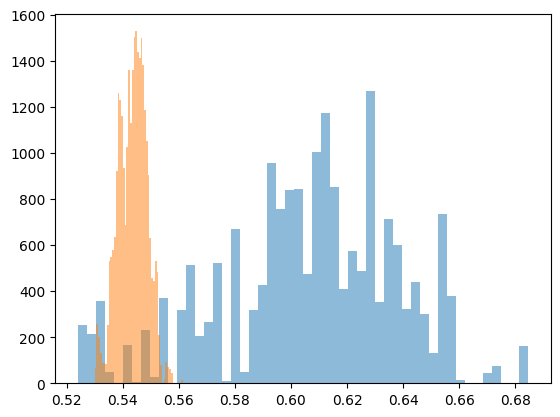

In [21]:
feature_to_plot = 5
plt.hist(Xs[:, feature_to_plot], bins=50, alpha=0.5)
plt.hist(Xt[:, feature_to_plot], bins=50, alpha=0.5)
plt.plot()

[]

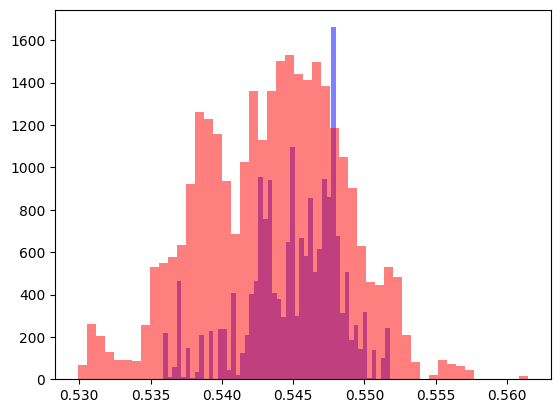

In [23]:
feature_to_plot = 5
plt.hist(Xst[:, feature_to_plot], bins=50, alpha=0.5, color='blue')
plt.hist(Xt[:, feature_to_plot], bins=50, alpha=0.5, color='red')
plt.plot()

[]

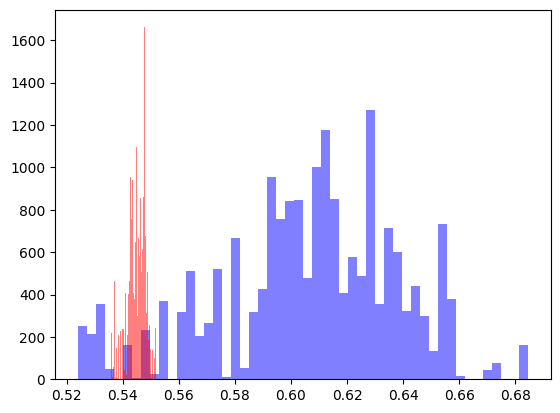

In [24]:
feature_to_plot = 5
plt.hist(Xs[:, feature_to_plot], bins=50, alpha=0.5, color='blue')
plt.hist(Xst[:, feature_to_plot], bins=50, alpha=0.5, color='red')
plt.plot()

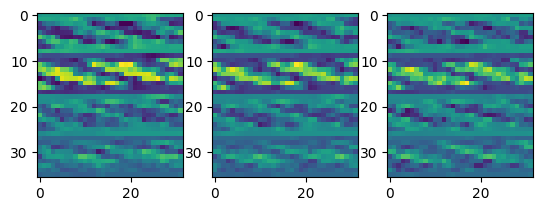

In [27]:
f, axarr = plt.subplots(1,3) 

axarr[0].imshow(Xs[0].reshape(36, 32))
axarr[1].imshow(Xst[0].reshape(36, 32))
axarr[2].imshow(Xt[0].reshape(36, 32))
plt.show()

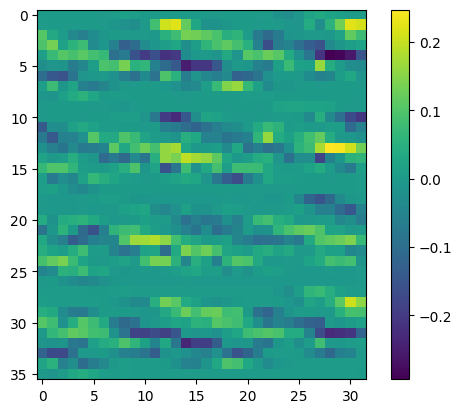

In [29]:
plt.imshow(Xt[0].reshape(36, 32) - Xst[0].reshape(36, 32))
plt.colorbar()

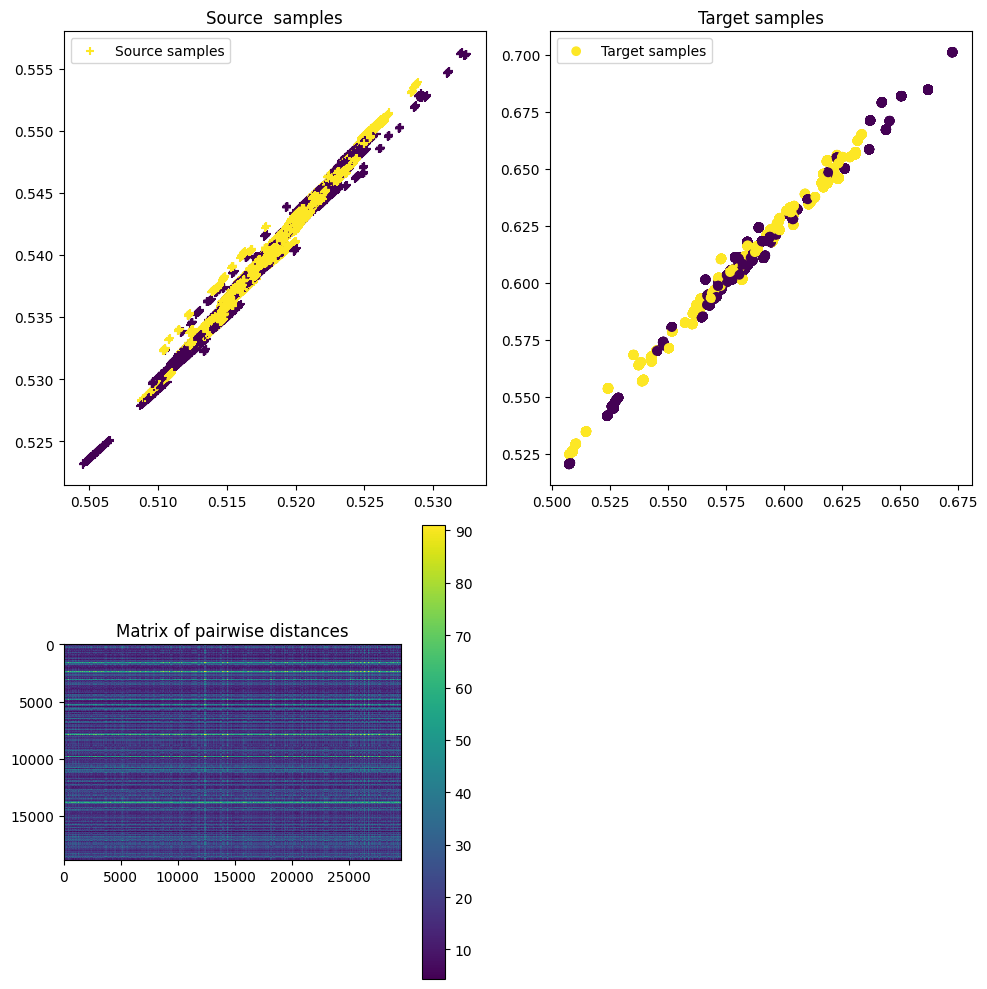

In [30]:
M = ot.dist(Xs, Xt, metric='sqeuclidean')

pl.figure(1, figsize=(10, 10))
pl.subplot(2, 2, 1)
pl.scatter(X_nyu[:, 0], X_nyu[:, 1], c=y_nyu, marker='+', label='Source samples')
pl.legend(loc=0)
pl.title('Source  samples')

pl.subplot(2, 2, 2)
pl.scatter(X_um1_train[:, 0], X_um1_train[:, 1], c=y_um1_train, marker='o', label='Target samples')
pl.legend(loc=0)
pl.title('Target samples')

pl.subplot(2, 2, 3)
pl.imshow(M, interpolation='nearest')
pl.colorbar()
pl.title('Matrix of pairwise distances')
pl.tight_layout()

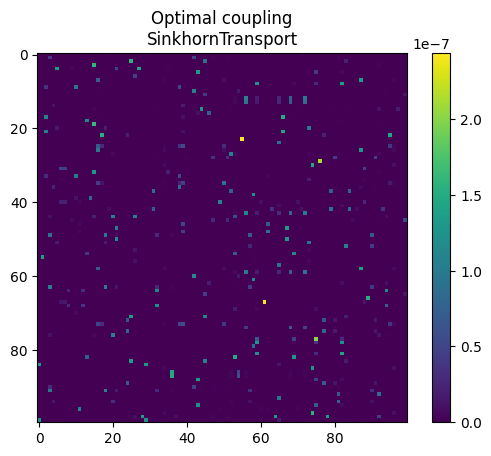

In [31]:
# pl.figure(2, figsize=(20, 10))

# pl.subplot(2, 3, 1)
# pl.imshow(ot_emd.coupling_, interpolation='nearest')
# pl.xticks([])
# pl.yticks([])
# pl.title('Optimal coupling\nEMDTransport')

# pl.subplot(2, 3, 2)
pl.imshow(ot_sinkhorn.coupling_[0:100, 0:100])
pl.title('Optimal coupling\nSinkhornTransport')
pl.colorbar()
plt.show()
# 
# pl.subplot(2, 3, 3)
# pl.imshow(ot_lpl1.coupling_, interpolation='nearest')
# pl.xticks([])
# pl.yticks([])
# pl.title('Optimal coupling\nSinkhornLpl1Transport')

# pl.subplot(2, 3, 4)
# ot.plot.plot2D_samples_mat(Xs, Xt, ot_emd.coupling_, c=[.5, .5, 1])
# pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
# pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
# pl.title('Main coupling coefficients\nEMDTransport')

# pl.subplot(2, 3, 5)
# ot.plot.plot2D_samples_mat(Xs, Xt, ot_sinkhorn.coupling_, c=[.5, .5, 1])
# pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
# pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
# pl.title('Main coupling coefficients\nSinkhornTransport')
# 
# pl.subplot(2, 3, 6)
# ot.plot.plot2D_samples_mat(Xs, Xt, ot_lpl1.coupling_, c=[.5, .5, 1])
# pl.scatter(Xs[:, 0], Xs[:, 1], c=ys, marker='+', label='Source samples')
# pl.scatter(Xt[:, 0], Xt[:, 1], c=yt, marker='o', label='Target samples')
# pl.xticks([])
# pl.yticks([])
# pl.title('Main coupling coefficients\nSinkhornLpl1Transport')
# pl.tight_layout()

# Train an SVM on NYU

In [30]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model = SVC(kernel="rbf", C=1.0, class_weight='balanced', random_state=42, verbose=True)
model.fit(X=X_nyu, y=y_nyu)

[LibSVM]......
*
optimization finished, #iter = 6948
obj = -2785.389235, rho = -1.739781
nSV = 5595, nBSV = 3815
Total nSV = 5595


SVC(class_weight='balanced', random_state=42, verbose=True)

In [31]:
model.fit_status_ == 0

True

{'accuracy': 0.9999999999661865,
 'recall': 0.9999999999410863,
 'precision': 0.9999999999410863}

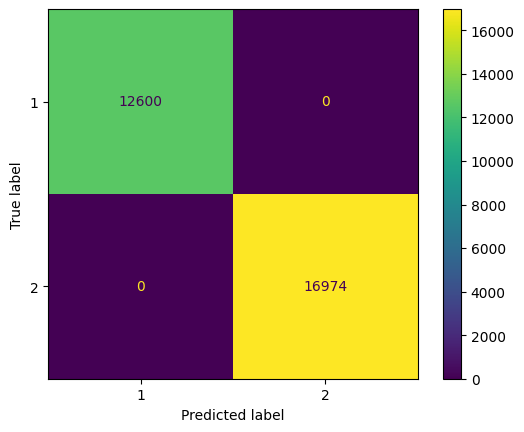

In [32]:
test_predictions = model.predict(X_nyu)
cm = confusion_matrix(y_nyu, test_predictions, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot()
tn, fp, fn, tp = cm.ravel()
metrics = {
    'accuracy': ((tp + tn) / (tp + tn + fp + fn + 1e-6)),
    'recall': (tp / (tp + fn + 1e-6)),
    'precision': (tp / (tp + fp + 1e-6))
}
metrics

{'accuracy': 0.4756355931195687,
 'recall': 0.181582840169533,
 'precision': 0.6520584320689795}

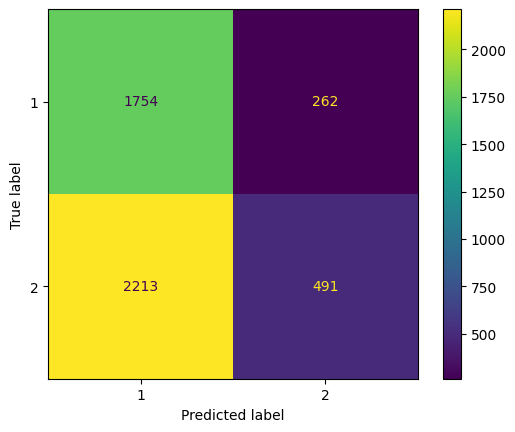

In [33]:
test_predictions = model.predict(X_um1_test)
cm = confusion_matrix(y_um1_test, test_predictions, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot()
tn, fp, fn, tp = cm.ravel()
metrics = {
    'accuracy': ((tp + tn) / (tp + tn + fp + fn + 1e-6)),
    'recall': (tp / (tp + fn + 1e-6)),
    'precision': (tp / (tp + fp + 1e-6))
}
metrics

In [34]:
test_predictions = model.predict(Xst)

ValueError: Found input variables with inconsistent numbers of samples: [4720, 18879]

{'accuracy': 0.5317018909618252,
 'recall': 0.8146512055204628,
 'precision': 0.5645768224654265}

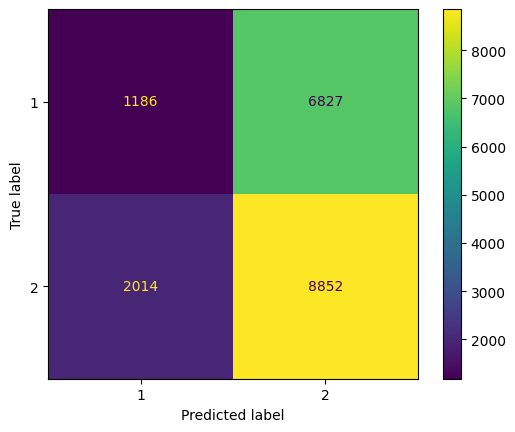

In [35]:
cm = confusion_matrix(ys, test_predictions, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot()
tn, fp, fn, tp = cm.ravel()
metrics = {
    'accuracy': ((tp + tn) / (tp + tn + fp + fn + 1e-6)),
    'recall': (tp / (tp + fn + 1e-6)),
    'precision': (tp / (tp + fp + 1e-6))
}
metrics